<a href="https://colab.research.google.com/github/skyshine460/Loan-Approval-Prediction/blob/main/baseline_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

In [2]:
train = pd.read_csv("/content/drive/MyDrive/Loan Approval Prediction/playground-series-s4e10/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Loan Approval Prediction/playground-series-s4e10/test.csv")
sample_submit = pd.read_csv("/content/drive/MyDrive/Loan Approval Prediction/playground-series-s4e10/sample_submission.csv", header=None)

In [3]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:  # Exclude object types
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:  # Float types
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by: {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
application = reduce_mem_usage(train)

Memory usage of dataframe is 5.82 MB
Memory usage after optimization is: 2.96 MB
Decreased by: 49.0%


In [5]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    return info_df

print(train.shape)
information_df(train)

(58645, 13)


,dtypes,NaN Count,Nunique,Unique Values
id,int32,0,58645,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
person_age,int8,0,53,"[37, 22, 29, 30, 27, 25, 21, 35, 31, 26, 28, 3..."
person_income,int32,0,2641,"[35000, 56000, 28800, 70000, 60000, 45000, 200..."
person_home_ownership,object,0,4,"[RENT, OWN, MORTGAGE, OTHER]"
person_emp_length,float16,0,36,"[0.0, 6.0, 8.0, 14.0, 2.0, 9.0, 11.0, 5.0, 1.0..."
loan_intent,object,0,6,"[EDUCATION, MEDICAL, PERSONAL, VENTURE, DEBTCO..."
loan_grade,object,0,7,"[B, C, A, D, E, F, G]"
loan_amnt,int32,0,545,"[6000, 4000, 12000, 9000, 2500, 5000, 15000, 1..."
loan_int_rate,float16,0,359,"[11.49, 13.35, 8.9, 11.11, 6.92, 8.94, 6.54, 1..."
loan_percent_income,float16,0,61,"[0.17, 0.07, 0.21, 0.1, 0.2, 0.27, 0.13, 0.14,..."


*   id: 各申請者の一意な識別子。
*   person_age: 申請者の年齢。
*   person_income: 申請者の年収。
*   person_home_ownership: 申請者の住宅所有状況（例：持ち家、賃貸など）。
*   person_emp_length: 申請者の雇用年数（年単位）。
*   loan_intent: ローンの目的（例：教育、ビジネスなど）。
*   loan_grade: ローンのグレード（信用リスクの評価）。
*   loan_amnt: 申請されたローンの金額。
*   loan_int_rate: ローンの金利。
*   loan_percent_income: 申請者の収入に対するローン金額の割合。
*   cb_person_default_on_file: 申請者の信用履歴のデフォルト情報（有無）。
*   cb_person_cred_hist_length: 申請者の信用履歴の長さ（年単位）。
*   loan_status: ローンの承認ステータス（例：承認、非承認）。

In [6]:
print(test.shape)
information_df(test)

(39098, 12)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,39098,"[58645, 58646, 58647, 58648, 58649, 58650, 586..."
person_age,int64,0,52,"[23, 26, 33, 32, 22, 29, 25, 27, 21, 38, 30, 4..."
person_income,int64,0,2196,"[69000, 96000, 30000, 50000, 102000, 66000, 75..."
person_home_ownership,object,0,4,"[RENT, MORTGAGE, OWN, OTHER]"
person_emp_length,float64,0,31,"[3.0, 6.0, 5.0, 4.0, 8.0, 10.0, 0.0, 1.0, 2.0,..."
loan_intent,object,0,6,"[HOMEIMPROVEMENT, PERSONAL, VENTURE, DEBTCONSO..."
loan_grade,object,0,7,"[F, C, E, A, D, B, G]"
loan_amnt,int64,0,482,"[25000, 10000, 4000, 7000, 15000, 22000, 8000,..."
loan_int_rate,float64,0,336,"[15.76, 12.68, 17.19, 8.9, 16.32, 14.09, 10.62..."
loan_percent_income,float64,0,63,"[0.36, 0.1, 0.13, 0.14, 0.15, 0.33, 0.11, 0.12..."


In [7]:
print(sample_submit.shape)
information_df(sample_submit)

(39099, 2)


,dtypes,NaN Count,Nunique,Unique Values
0,object,0,39099,"[id, 58645, 58646, 58647, 58648, 58649, 58650,..."
1,object,0,2,"[loan_status, 0.5]"


<ipython-input-8-f20af7c0d2f0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], fit=norm, ax=ax[0])


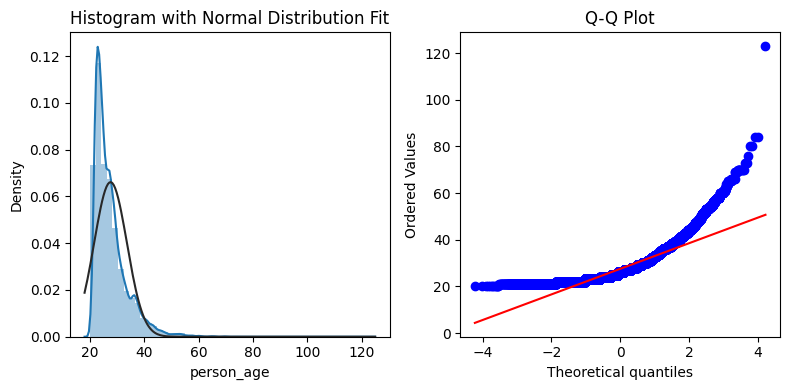

Skewness: 1.9654967033657
Kurtosis: 6.408379567393629


In [8]:
# 学習データの分布の確認
def normal_distribution_fit(df, col):
  fig, ax = plt.subplots(1, 2, figsize=(8, 4))

  sns.distplot(df[col], fit=norm, ax=ax[0])
  ax[0].set_title('Histogram with Normal Distribution Fit')

  stats.probplot(df[col], plot=ax[1])
  ax[1].set_title('Q-Q Plot')

  plt.tight_layout()
  plt.show()

  print(f"Skewness: {df[col].skew()}")
  print(f"Kurtosis: {df[col].kurt()}")

normal_distribution_fit(train, 'person_age')

<ipython-input-8-f20af7c0d2f0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], fit=norm, ax=ax[0])


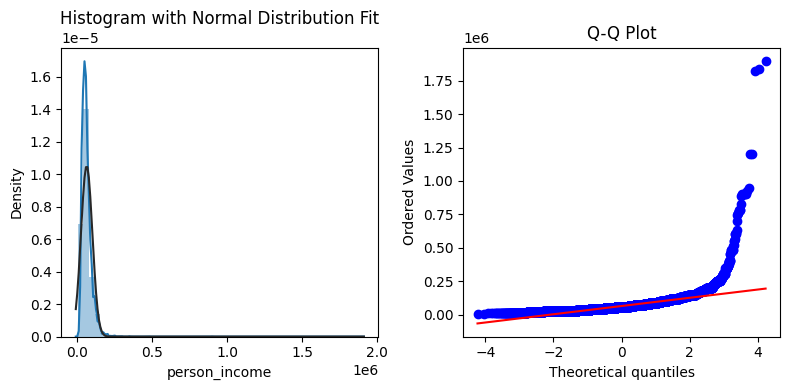

Skewness: 10.457722504927045
Kurtosis: 342.6293525072882


In [9]:
normal_distribution_fit(train, 'person_income')

<ipython-input-8-f20af7c0d2f0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], fit=norm, ax=ax[0])


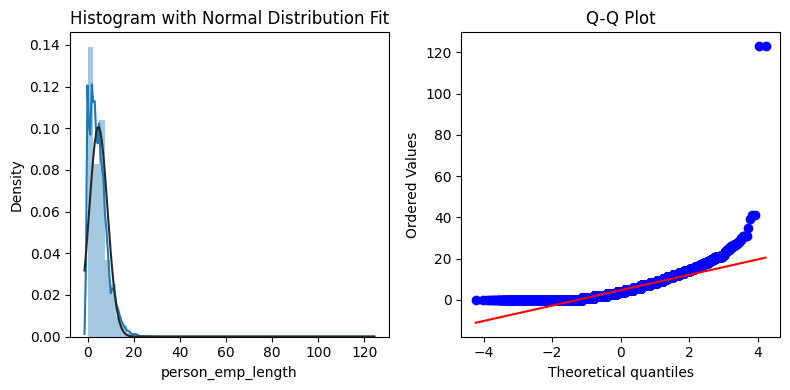

Skewness: inf
Kurtosis: inf


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1260: RuntimeWarning: overflow encountered in multiply
  adjusted3 = adjusted2 * adjusted
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1348: RuntimeWarning: overflow encountered in square
  adjusted4 = adjusted2**2


In [10]:
normal_distribution_fit(train, 'person_emp_length')

<ipython-input-8-f20af7c0d2f0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], fit=norm, ax=ax[0])


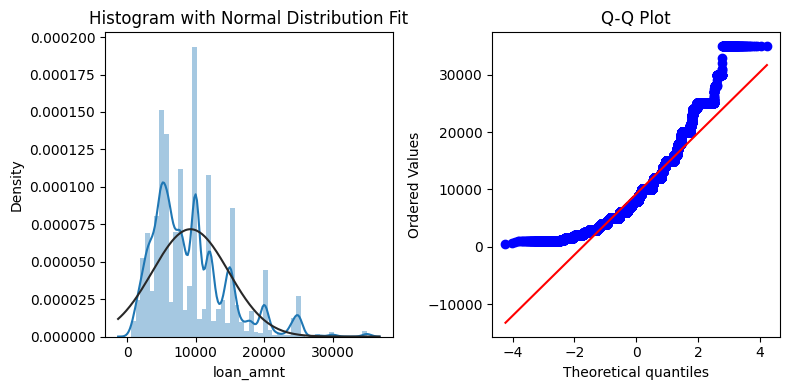

Skewness: 1.1885784743437686
Kurtosis: 1.6937836745265122


In [11]:
normal_distribution_fit(train, 'loan_amnt')

<ipython-input-8-f20af7c0d2f0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], fit=norm, ax=ax[0])


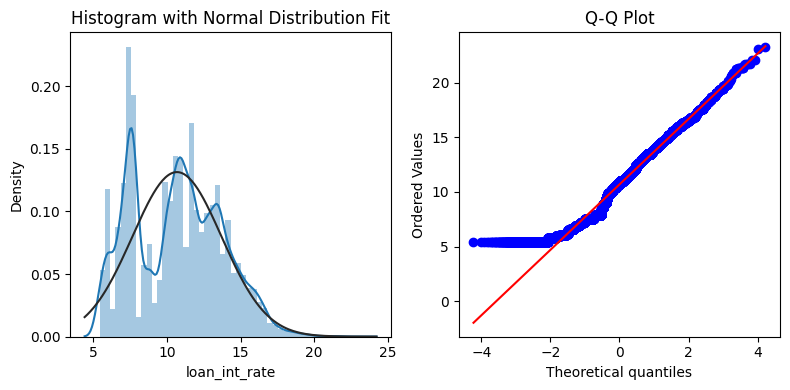

Skewness: 0.1982421875
Kurtosis: -0.71826171875


In [12]:
normal_distribution_fit(train, 'loan_int_rate')

<ipython-input-8-f20af7c0d2f0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], fit=norm, ax=ax[0])


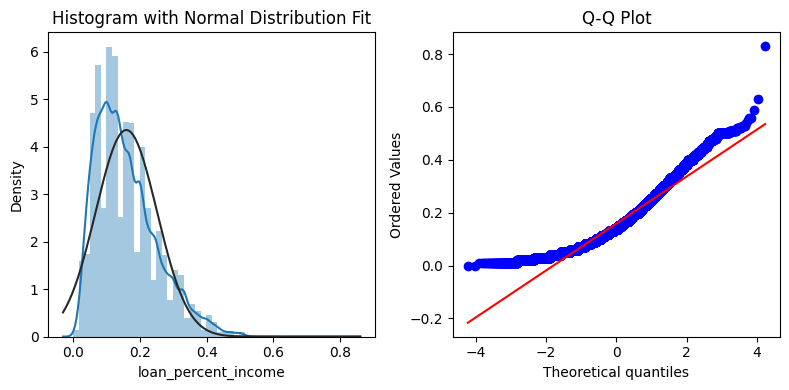

Skewness: 0.91943359375
Kurtosis: 0.6337890625


In [13]:
normal_distribution_fit(train, 'loan_percent_income')

<ipython-input-8-f20af7c0d2f0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], fit=norm, ax=ax[0])


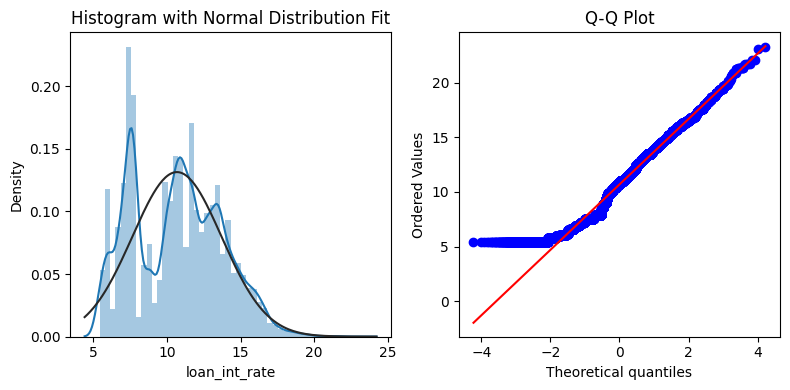

Skewness: 0.1982421875
Kurtosis: -0.71826171875


In [14]:
normal_distribution_fit(train, 'loan_int_rate')

<ipython-input-8-f20af7c0d2f0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], fit=norm, ax=ax[0])


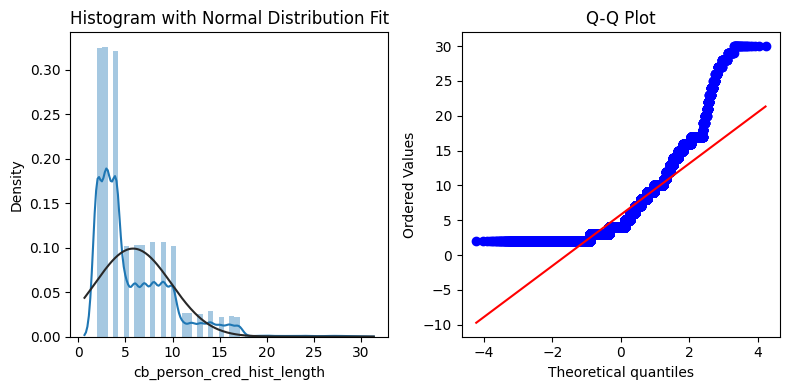

Skewness: 1.6185028956126892
Kurtosis: 3.4907748950955466


In [15]:
normal_distribution_fit(train, 'cb_person_cred_hist_length')

<Axes: xlabel='loan_status', ylabel='Count'>

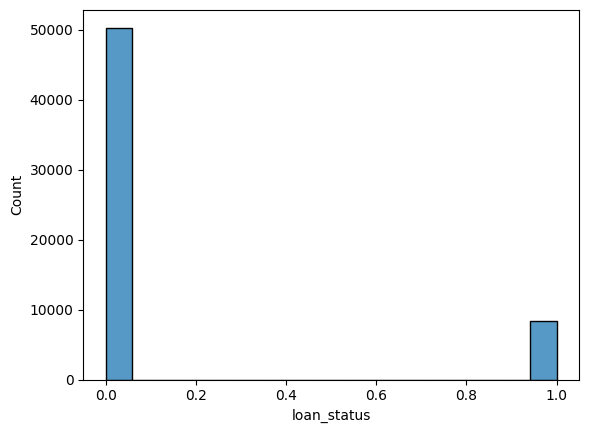

In [16]:
sns.histplot(data=train, x="loan_status")

In [41]:
x_train = train.drop(columns=["id", "loan_status"])
y_train = train["loan_status"]
id_train = train["id"]

In [47]:
# x_trainの各列をチェックしてobject型をカテゴリ型に変換する
for col in x_train.columns:
    if x_train[col].dtype == "object":  # object型の列を探す
        x_train[col] = x_train[col].astype("category")  # カテゴリ型に変換

In [48]:
x_train.dtypes

,0
person_age,int8
person_income,int32
person_home_ownership,category
person_emp_length,float16
loan_intent,category
loan_grade,category
loan_amnt,int32
loan_int_rate,float16
loan_percent_income,float16
cb_person_default_on_file,category


In [49]:
print("mean: {:.4f}".format(y_train.mean()))
y_train.value_counts()

mean: 0.1424


,count
loan_status,
0,50295
1,8350


In [50]:
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(x_train, y_train))

print("index(train):", cv[0][0])
print("index(valid):", cv[0][1])

nfold = 0
idx_tr, idx_va = cv[nfold][0], cv[nfold][1]

x_tr = x_train.iloc[idx_tr]
y_tr = y_train.iloc[idx_tr]
id_tr = id_train.iloc[idx_tr]

x_va = x_train.iloc[idx_va]
y_va = y_train.iloc[idx_va]
id_va = id_train.iloc[idx_va]

print(x_tr.shape, y_tr.shape, id_tr.shape)
print(x_va.shape, y_va.shape, id_va.shape)

index(train): [    0     1     2 ... 58642 58643 58644]
index(valid): [    7    11    14 ... 58632 58637 58638]
(46916, 11) (46916,) (46916,)
(11729, 11) (11729,) (11729,)


In [51]:
#ハイパーパラメータの設定
params = {
'boosting_type': 'gbdt',
'objective': 'binary',
'metric': 'auc',
'learning_rate': 0.05,
'num_leaves': 32,
'n_estimators': 100000,
"random_state": 123,
"importance_type": "gain",
}

In [57]:
import lightgbm as lgb
import pickle

model = lgb.LGBMClassifier(**params)
model.fit(x_tr,
          y_tr,
          eval_set=[(x_tr, y_tr), (x_va, y_va)],
          callbacks=[
              lgb.early_stopping(stopping_rounds=50, verbose=False),
              lgb.log_evaluation(0)]
          )

with open("model_lgb_fold0.pickle", "wb") as f:
  pickle.dump(model, f, protocol=4)

[LightGBM] [Info] Number of positive: 6680, number of negative: 40236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142382 -> initscore=-1.795644
[LightGBM] [Info] Start training from score -1.795644


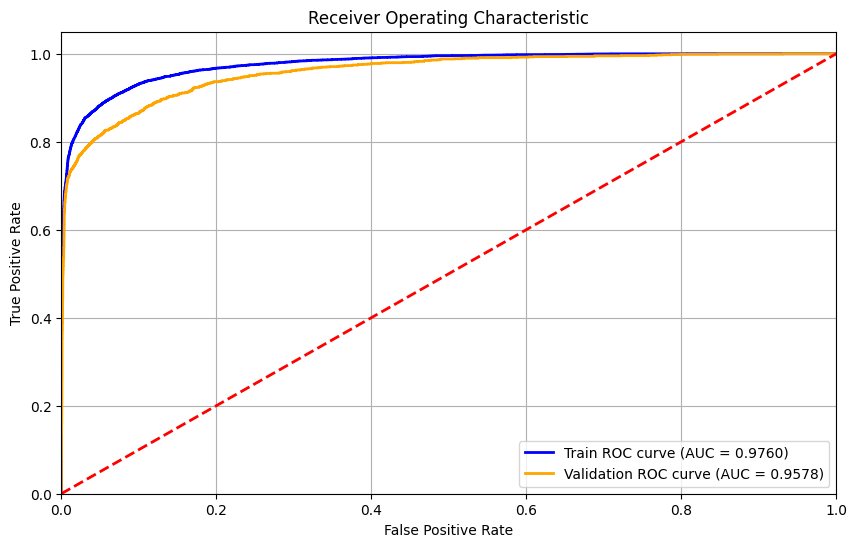

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_tr_pred = model.predict_proba(x_tr)[:, 1]
y_va_pred = model.predict_proba(x_va)[:, 1]

# ROC曲線のデータを計算
fpr_tr, tpr_tr, _ = roc_curve(y_tr, y_tr_pred)
fpr_va, tpr_va, _ = roc_curve(y_va, y_va_pred)

# AUCを計算
roc_auc_tr = auc(fpr_tr, tpr_tr)
roc_auc_va = auc(fpr_va, tpr_va)

# ROC曲線を描画
plt.figure(figsize=(10, 6))
plt.plot(fpr_tr, tpr_tr, color='blue', lw=2, label='Train ROC curve (AUC = {:.4f})'.format(roc_auc_tr))
plt.plot(fpr_va, tpr_va, color='orange', lw=2, label='Validation ROC curve (AUC = {:.4f})'.format(roc_auc_va))

# ランダムな予測のための基準線
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)

# 軸ラベルとタイトルを設定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [62]:
imp_fold = pd.DataFrame({"col": x_train.columns, "imp": model.feature_importances_, "nfold": nfold})

display(imp_fold.sort_values("imp", ascending=False)[:10])

imp = pd.DataFrame()
imp = pd.concat([imp, imp_fold])

,col,imp,nfold
8,loan_percent_income,83087.970389,0
5,loan_grade,71798.053814,0
2,person_home_ownership,33839.440043,0
1,person_income,33122.775563,0
4,loan_intent,15010.414992,0
7,loan_int_rate,13053.648771,0
3,person_emp_length,11535.142295,0
0,person_age,3979.824152,0
6,loan_amnt,3902.308942,0
10,cb_person_cred_hist_length,1510.194986,0


In [81]:
import numpy as np
import pandas as pd
import pickle
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import matplotlib.pyplot as plt

def calculate_youden_j(fpr, tpr, thresholds):
    """YoudenのJ統計量を計算し、最適なしきい値を見つける関数"""
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    max_youden_j = youden_j[optimal_idx]
    return optimal_idx, optimal_threshold, max_youden_j

def plot_roc_curves(roc_curves, thresholds, nfolds):
    """ROC曲線を描画する関数"""
    plt.figure(figsize=(10, 6))
    for i, (fpr, tpr) in enumerate(roc_curves):
        plt.plot(fpr, tpr, lw=1, label=f'Fold {i}')  # 各フォールドのROC曲線をプロット

    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')  # ランダム予測の基準線

    # YoudenのJ統計量の計算とプロット
    for i, (fpr, tpr) in enumerate(roc_curves):
        optimal_idx, optimal_threshold, max_youden_j = calculate_youden_j(fpr, tpr, thresholds[i])
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o',
                    label=f'Fold {i} Optimal J: {max_youden_j:.2f}, Threshold: {optimal_threshold:.2f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Cross-Validation')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

def train_lgb(input_x, input_y, input_id, params, list_nfold=[0, 1, 2, 3, 4], n_splits=5):
    train_oof = np.zeros(len(input_x))
    metrics = []
    imp = pd.DataFrame()
    roc_curves = []  # ROC曲線データを保存するリスト
    thresholds_list = []  # しきい値を保存するリスト

    # クロスバリデーションの設定
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x, input_y))

    for nfold in list_nfold:
        print("-" * 20, nfold, "-" * 20)

        # データセットの分割
        idx_tr, idx_va = cv[nfold]
        x_tr, y_tr = input_x.iloc[idx_tr], input_y.iloc[idx_tr]
        x_va, y_va = input_x.iloc[idx_va], input_y.iloc[idx_va]
        print("Train shape:", x_tr.shape, "Validation shape:", x_va.shape)

        # モデルのトレーニング
        model = LGBMClassifier(**params)
        model.fit(
            x_tr, y_tr,
            eval_set=[(x_tr, y_tr), (x_va, y_va)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)]
        )

        # モデルの保存
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "wb") as f:
            pickle.dump(model, f, protocol=4)

        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:, 1]
        y_va_pred = model.predict_proba(x_va)[:, 1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        metrics.append([nfold, metric_tr, metric_va])
        print("[AUC] Train: {:.4f}, Validation: {:.4f}".format(metric_tr, metric_va))

        # Out-of-Fold予測
        train_oof[idx_va] = y_va_pred

        # ROC曲線のデータを保存
        fpr, tpr, thresholds = roc_curve(y_va, y_va_pred)
        roc_curves.append((fpr, tpr))
        thresholds_list.append(thresholds)

        # 最適なしきい値を計算して出力
        optimal_idx, optimal_threshold, max_youden_j = calculate_youden_j(fpr, tpr, thresholds)
        print(f"[Fold {nfold}] Optimal Threshold: {optimal_threshold:.4f}, J: {max_youden_j:.4f}")

        # 特徴量の重要度
        _imp = pd.DataFrame({"col": input_x.columns, "imp": model.feature_importances_, "nfold": nfold})
        imp = pd.concat([imp, _imp])

    print("-" * 20, "Result", "-" * 20)

    # メトリックの表示
    metrics = np.array(metrics)
    print(metrics)
    print("[CV] Train: {:.4f} ± {:.4f}, Validation: {:.4f} ± {:.4f}".format(
        metrics[:, 1].mean(), metrics[:, 1].std(),
        metrics[:, 2].mean(), metrics[:, 2].std(),
    ))
    print("[OOF] {:.4f}".format(roc_auc_score(input_y, train_oof)))

    # Out-of-Fold DataFrame
    train_oof_df = pd.concat([input_id.reset_index(drop=True), pd.DataFrame({"pred": train_oof})], axis=1)

    # 特徴量の重要度を集計
    imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index(drop=False)
    imp.columns = ["col", "imp", "imp_std"]

    # ROC曲線を描画
    plot_roc_curves(roc_curves, thresholds_list, len(list_nfold))

    return train_oof_df, imp, metrics

-------------------- 0 --------------------
Train shape: (46916, 11) Validation shape: (11729, 11)
[LightGBM] [Info] Number of positive: 6680, number of negative: 40236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142382 -> initscore=-1.795644
[LightGBM] [Info] Start training from score -1.795644
[AUC] Train: 0.9760, Validation: 0.9578
[Fold 0] Optimal Threshold: 0.1641, J: 0.7693
-------------------- 1 --------------------
Train shape: (46916, 11) Validation shape: (11729, 11)
[LightGBM] [Info] Number of positive: 6680, number of negative: 40236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00

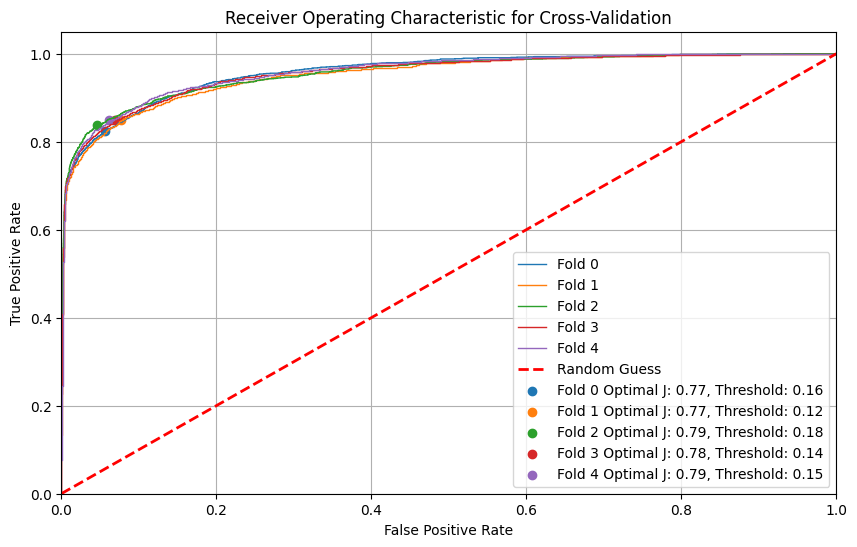

In [82]:
#ハイパーパラメータの設定
params = {
'boosting_type': 'gbdt',
'objective': 'binary',
'metric': 'auc',
'learning_rate': 0.05,
'num_leaves': 32,
'n_estimators': 100000,
"random_state": 123,
"importance_type": "gain",
}
# 学習の実行
train_oof, imp, metrics = train_lgb(
    x_train,
    y_train,
    id_train,
    params,
    list_nfold=[0, 1, 2, 3, 4],
    n_splits=5,
)

In [69]:
imp.sort_values("imp", ascending=False)[:10]

,col,imp,imp_std
6,loan_percent_income,84599.696546,1189.527880
3,loan_grade,71821.720584,842.382461
10,person_income,37333.432134,2558.240917
9,person_home_ownership,33831.199773,465.905691
4,loan_int_rate,16996.552069,2480.583013
5,loan_intent,14984.370653,237.310746
8,person_emp_length,12509.917033,765.531522
2,loan_amnt,5413.830573,926.421075
7,person_age,5329.814215,894.359893
0,cb_person_cred_hist_length,2391.886741,717.037438


# testデータの予測

In [70]:
test = reduce_mem_usage(test)

x_test = test.drop(columns=["id"])
test_id = test["id"]

for col in x_test.columns:
    if x_test[col].dtype == "object":
        x_test[col] = x_test[col].astype("category")

Memory usage of dataframe is 3.58 MB
Memory usage after optimization is: 1.94 MB
Decreased by: 45.8%


In [83]:
with open("model_lgb_fold0.pickle", "rb") as f:
  model = pickle.load(f)

y_test_pred = model.predict_proba(x_test)[:, 1]

test_pred = np.zeros((len(x_test), 5))
test_pred[:, 0] = y_test_pred

test_pred_mean = test_pred.mean(axis=1)

test_pred_mean = pd.DataFrame({"id": test_id, "pred": test_pred_mean})
test_pred_mean.head()

,id,pred
0,58645,0.197311
1,58646,0.002747
2,58647,0.132486
3,58648,0.002344
4,58649,0.014399


# 提出データの作成

In [ ]:
df_submit = pd.DataFrame({
    'id': sample_submit["id"],
    'loan_status': test["loan_status"]
})

df_submit.head()

In [ ]:
df_submit.to_csv("submission.csv", index=False)